In [1]:
# The aim of this case study is to load the latest Agricultural Stress Index (ASI) data from FAO Essential Remote Se3nsing Data Product Potal, 
# and use a country country boundary (Italy in this case study) to crop the data and share save the data to the users' cloud / laptop 
# Created by Pengyu Hao (pengyu.hao@fao.org) on 2026/1/19 

# User need to go through the data collections page (https://data.apps.fao.org/remote-sensing-portal/collections) of the 
# Essential Remote Sensing Data Product Portal to find the collection ID they need, 
# in this case, it is "ASI-D"

In [30]:
from pystac_client import Client
from datetime import datetime, timedelta
from urllib.parse import urlparse
import leafmap
import gcsfs
import tempfile
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.env import Env
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
import geopandas as gpd
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
#the link to the stac in production
API_ROOT = "https://data.apps.fao.org/geospatial/search/stac"
#using client functions to see all collections available in the STAC
client = Client.open(API_ROOT)

In [16]:
#input filters for data selection
# === EDIT THESE ===
# You can put: []  or ""  or None  to search without a collection filter.
# Or provide one or many collection ids, e.g. ["L1-UTM-NPP-D"] or "L1-UTM-NPP-D"
COLLECTIONS = "ASI-D"   # or [] or None
# Bounding box in WGS84 [minx, miny, maxx, maxy]; set to None to ignore
BBOX =[6, 36, 20, 48]   # or None
# Time range; set to None to ignore (STAC interval string "start/end")
#create the time as 15 days ago:
now = datetime.now()
days_ago = 25
#fifteen_days_ago = now - timedelta(days=days_ago)
starttime_str = (datetime.now() - timedelta(days=days_ago)).strftime("%Y-%m-%d")
#print(starttime_str)
DATETIME = starttime_str+"/2999-12-31"  # or None
# Optional: LIKE pattern for item id (SQL wildcards: % = any string, _ = single char)
# Example: "%60W.2024-12-D3%"  |  set to None to skip LIKE filtering
ITEM_ID_LIKE = None
# Optional extra STAC 'query' filter
QUERY = {
    # "eo:cloud_cover": {"lt": 20}
}
# Optional cap on results
LIMIT = 100
print("STAC_API:", API_ROOT)
print("COLLECTIONS:", COLLECTIONS)
print("BBOX:", BBOX)
print("DATETIME:", DATETIME)
print("ITEM_ID_LIKE:", ITEM_ID_LIKE)

STAC_API: https://data.apps.fao.org/geospatial/search/stac
COLLECTIONS: ASI-D
BBOX: [6, 36, 20, 48]
DATETIME: 2025-12-26/2999-12-31
ITEM_ID_LIKE: None


In [17]:
#functions to select items from collection
def _normalize_collections(val):
    if val is None:
        return None
    if isinstance(val, str):
        val = val.strip()
        return [val] if val else None
    if isinstance(val, (list, tuple)):
        vals = [v for v in (x.strip() for x in val) if v]
        return vals or None
    return None

search_kwargs = dict(
    collections=_normalize_collections(COLLECTIONS),
    bbox=BBOX or None,
    datetime=DATETIME or None,
    query=QUERY or None,
    limit=LIMIT,
)

#get and show the list of the selected items of the recent 15 day.
# Add LIKE filter only if user provided ITEM_ID_LIKE
if ITEM_ID_LIKE:
    search_kwargs.update({
        "filter_lang": "cql2-json",
        "filter": {
            "op": "like",
            "args": [
                {"property": "id"},
                ITEM_ID_LIKE
            ]
        }
    })

search = client.search(**search_kwargs)
items = list(search.get_items())
for item in items:
    print(item.id)
#print(len(items))

ASIS.ASI-D.2026-01-D1.GS2.LC-G
ASIS.ASI-D.2026-01-D1.GS2.LC-C
ASIS.ASI-D.2026-01-D1.GS1.LC-G
ASIS.ASI-D.2026-01-D1.GS1.LC-C
ASIS.ASI-D.2025-12-D3.GS2.LC-G
ASIS.ASI-D.2025-12-D3.GS2.LC-C
ASIS.ASI-D.2025-12-D3.GS1.LC-G
ASIS.ASI-D.2025-12-D3.GS1.LC-C


In [24]:
#select the items with the latest time phase
# among selected items, select the image of growing season 1 with cropland
def get_last_timephase(itemlist):
    #print(item_str)
    #get the time phase list
    time_list = []
    for tmp_item in itemlist:
        #tmp_item = items[0]
        tmp_str = tmp_item.id
        #print(tmp_str)
        index = tmp_str.find("GS")
        #print(index)
        time_str = tmp_str[index-11:index-1]
        #print(time_str)
        #time_list = []
        if time_str in time_list:
            continue
        else:
            time_list.append(time_str)
    
    #get the latest time phase
    #print(time_list)
    time_list.sort(reverse=True)
    time_latest = time_list[0]
        
    #keep the items with the latest time phase in the list
    item_list_latest = []
    for tmp_item in items:
        #tmp_item = items[0]
        tmp_str = tmp_item.id
        #print(tmp_str)
        index = tmp_str.find("GS")
        #print(index)
        time_str = tmp_str[index-11:index-1]
        if time_str == time_latest:
            item_list_latest.append(tmp_item)

    return item_list_latest

def get_SingleItem_GS_LC(itemlist, GS, LC):
    item_list_tmp = []
    for tmp_item in items:
        tmp_str = tmp_item.id
        if (GS in tmp_str):
            if (LC in tmp_str):
                item_list_tmp.append(tmp_item)
    if len(item_list_tmp) > 0:
        return item_list_tmp[0]
    else:
        return None
        
itemlist_latest = get_last_timephase(items)
item_use = get_SingleItem_GS_LC(itemlist_latest, "GS1", "LC-C")
print(item_use)

<Item id=ASIS.ASI-D.2026-01-D1.GS1.LC-C>


In [27]:
# among selected items, download the image of growing season 1 with cropland
PREVIEW_SCALE = 16                 # 8 = sharper, 16 = faster, 32 = fastest
DOWNLOAD_CHUNK = 8 * 1024 * 1024   # 8MB streaming chunks
def _is_geotiff(a):
    mt = (a.media_type or "").lower()
    href = (a.href or "").lower()
    return ("image/tiff" in mt) or href.endswith((".tif", ".tiff"))

# pick asset
def pick_asset(it):
    preferred = ("data", "visual", "rendered_preview", "B04", "B03", "B02", "nir")
    for k in preferred:
        if k in it.assets and _is_geotiff(it.assets[k]):
            return it.assets[k], k
    for k, a in it.assets.items():
        if _is_geotiff(a):
            return a, k
    return None, None
    
# function to normalize the gs path
def normalize_to_gs(href: str) -> str:
    if not href:
        return href
    if href.startswith("gs://"):
        return href

    if "storage.cloud.google.com" in href:
        p = urlparse(href)
        path = p.path.lstrip("/")  # bucket/object
        return f"gs://{path}"

    if "storage.googleapis.com" in href:
        p = urlparse(href)
        parts = p.path.lstrip("/").split("/", 1)
        if len(parts) == 2:
            bucket, obj = parts
            return f"gs://{bucket}/{obj}"
    return href
#function to download data to compute engine
def download_gcs_to_temp(gs_uri: str, local_path) -> str:
    if not gs_uri.startswith("gs://"):
        return gs_uri
    fs = gcsfs.GCSFileSystem()
    bucket_and_key = gs_uri[5:]
    #tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
    #local_path = tmp.name
    #local_path = "/RSP_test/ASIS_test/GS1LCC/Global/"+"x.tif"
    print(f"Downloading (streamed) {gs_uri}")
    with fs.open(bucket_and_key, "rb") as src, open(local_path, "wb") as dst:
        while True:
            chunk = src.read(DOWNLOAD_CHUNK)
            if not chunk:
                break
            dst.write(chunk)
    return local_path

#download script
#local path base
Path_base = "/home/pengyu_hao_fao_org/"
Path_folder = "RSP_test/ASIS_test/GS1LCC/Global/"
#print(item.id)
Path_local = "/home/pengyu_hao_fao_org/" + "RSP_test/ASIS_test/GS1LCC/Global/" + item_use.id + ".tif"
asset, asset_key = pick_asset(item_use)
if not asset:
    raise RuntimeError(f"No GeoTIFF/COG asset found for item {item_use.id}")
href = asset.href or asset.get_absolute_href()
if not href:
    raise RuntimeError(f"Asset '{asset_key}' has no usable href.")
print(href)
gs_uri = normalize_to_gs(href)
#download the item to Path_local
download_gcs_to_temp(gs_uri, Path_local)


https://storage.cloud.google.com/fao-gismgr-asis-data/DATA/ASIS/MAPSET/ASI-D/ASIS.ASI-D.2026-01-D1.GS1.LC-C.tif


'/home/pengyu_hao_fao_org/RSP_test/ASIS_test/GS1LCC/Global/ASIS.ASI-D.2026-01-D1.GS1.LC-C.tif'

In [29]:
# using Italy boundary to clip and present visualization
shp_file = "/home/pengyu_hao_fao_org/Boundary/Global/shp/Global.shp"
output_raster_path = "/home/pengyu_hao_fao_org/" + "RSP_test/ASIS_test/GS1LCC/Italy/" + item_use.id + ".ITA.tif"
shp = fiona.open(shp_file)
#print(shp)
# The attribute and value you are looking for
attribute_name = 'ISO3CD'
attribute_value = 'ITA'

# Open the shapefile, and get the geometry of the selected feature
# with fiona.open(shapefile_path) as shapefile:
for feature in shp:
    # Check if the attribute matches the desired value
    if feature['properties'][attribute_name] == attribute_value:
        geom = feature['geometry']
        break
# Do something with the polygon (e.g., print it or process it)
#print(geom)

raster_ASIS_tmp = rasterio.open(Path_local)
out_ASIS_tmp_image, out_transform = mask(raster_ASIS_tmp,[geom],crop=True)
# Update the metadata of the output raster
out_meta = raster_ASIS_tmp.meta.copy()
out_meta.update({
    'height': out_ASIS_tmp_image.shape[1],
    'width': out_ASIS_tmp_image.shape[2],
    'transform': out_transform
})
#print(out_transform)
# Write the cropped raster to a new file
# export the selected image to folder
with rasterio.open(output_raster_path, 'w', **out_meta) as dest:
    dest.write(out_ASIS_tmp_image)
#print(out_ASIS_tmp_image)
print("data saved at: "+output_raster_path)

data saved at: /home/pengyu_hao_fao_org/RSP_test/ASIS_test/GS1LCC/Italy/ASIS.ASI-D.2026-01-D1.GS1.LC-C.ITA.tif


In [31]:
output_raster_path = "/home/pengyu_hao_fao_org/RSP_test/ASIS_test/GS1LCC/Italy/ASIS.ASI-D.2026-01-D1.GS1.LC-C.ITA.tif"

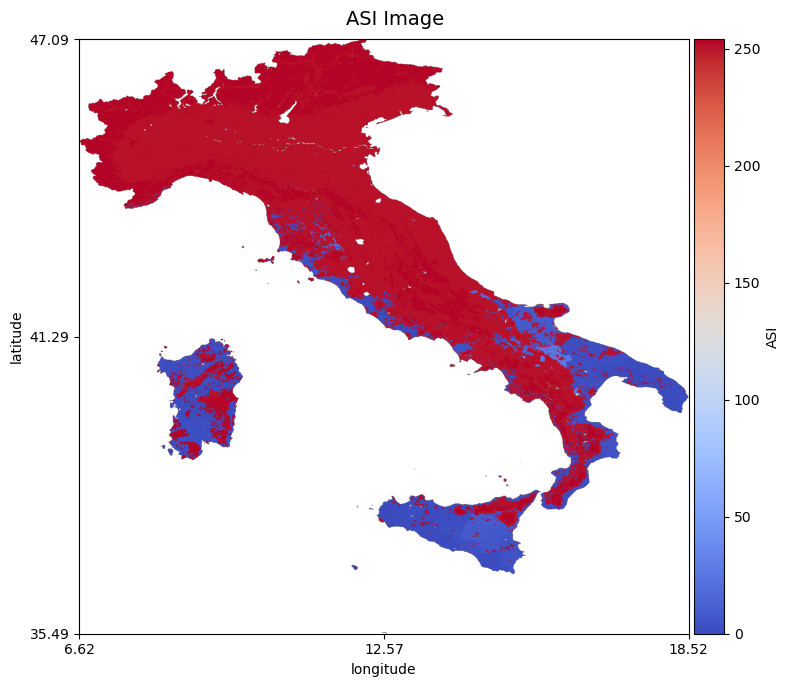

In [39]:
with rasterio.open(output_raster_path) as src:
    data = src.read(1)
    nodata = src.nodata

    # Mask NoData
    if nodata is not None:
        data = np.ma.masked_equal(data, nodata)

    # 2% percentile stretch
    vmin, vmax = np.percentile(data.compressed(), [1, 99])

    # Spatial extent (meters)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Raster plot
im = ax.imshow(
    data,
    extent=extent,
    origin="upper",
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax
)

# Axis labels
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# Three ticks per axis
ax.set_xticks([extent[0], (extent[0] + extent[1]) / 2, extent[1]])
ax.set_yticks([extent[2], (extent[2] + extent[3]) / 2, extent[3]])

# Full-height colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("ASI")

# Title at top of figure
fig.suptitle("ASI Image", fontsize=14, y=0.88)

# Leave room for the title
fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()